In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Build the ADNI training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [2]:
ADNI_core_df = pd.read_csv("/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/clinscore_data.csv")

In [3]:
uncertainty_type="punet"

In [4]:
uncertainty_type

'punet'

In [5]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/{uncertainty_type}_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [6]:
ent03 = load_model_output_stats("ent", 0.3)

In [7]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in extra_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
        extra_df = extra_df.drop(columns='ID')
        # print(extra_df['Patient ID'].values)
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'Patient ID' else 'Patient ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        # print(len(core_df))
        core_df = core_df.merge(extra_df, on="Patient ID")
        
    
    core_df = core_df.drop(columns='Patient ID')       
    
    return core_df

In [8]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

### Add the sample diversity data

In [9]:
if uncertainty_type != "deterministic":
    data_folder = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{uncertainty_type}/"
    all_data_files = os.listdir(data_folder)
    sample_div_files = [f for f in all_data_files if "sample_div" in f and "CHAL" not in f]

    dfs = [pd.read_csv(data_folder + f) for f in sample_div_files]

    sample_div_df = pd.concat(dfs)
    
    sample_div_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in sample_div_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
    sample_div_df = sample_div_df.drop(columns='ID')
    #sample_div_df.drop(columns='Unnamed: 0')
    
    ADNI_core_df = ADNI_core_df.merge(sample_div_df, on="Patient ID")

### fitting to predict fazekas

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [11]:
from tqdm import tqdm

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [13]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in extra_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
        extra_df = extra_df.drop(columns='ID')
        # print(extra_df['Patient ID'].values)
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'Patient ID' else 'Patient ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        # print(len(core_df))
        core_df = core_df.merge(extra_df, on="Patient ID")
        
    
    core_df = core_df.drop(columns='Patient ID')       
    
    return core_df

In [14]:
def remove_nans(dfc, verbose=False):
    nan_rows = dfc[dfc.isnull().any(axis=1)]
    nan_cols = dfc.columns[dfc.isnull().any()]
    if verbose:
        print("nans removed: ", len(nan_rows))
    dfc = dfc.drop(labels=nan_rows.index.values, axis=0)
    return dfc

In [15]:
def extract_Xy(df, label_class, verbose=False, kept_column=None, label_categories=None):
    df = remove_nans(df, verbose)
    if label_categories == None:
        label_categories = ['WMH_PV', 'WMH_Deep', 'Total', 'totatal_fazekas']
    if kept_column != None:
        y_reg = df[kept_column].values
    y = df[label_class].values
    X = df.drop(columns=label_categories)
    if label_class not in label_categories:
        X = X.drop(columns=label_class)
    if kept_column != None:
        X[kept_column] = y_reg
    return X, y

In [16]:
class Rescaler():
    def fit(self, X):
        norm_parameters = []
        for key in X.keys():
            values = X[key].values
            if len(np.unique(values)) > 2:
                mean = np.mean(values)
                std = np.std(values)
                norm_parameters.append((key, mean, std))
        self.norm_parameters = norm_parameters
    def predict(self, X):
        X = X.copy()
        for key, mean, std in self.norm_parameters:
            X[key] = (X[key] - mean) / std
        
        return X

In [17]:
def shuffle(df, random_state=42):
    df = df.copy()
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_hat, fig=None, ax=None):
    # Calculate N x N confusion matrix
    N = int(max(y_true) + 1)
    cm = confusion_matrix(y_true, y_hat)

    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    if fig == None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=0.9)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=range(N), yticklabels=range(N),
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.show()

## new training pipeline


configure so that I can pick a specific input type and threshold and included features.
Need the ability to include multiple sets of fields from the core df. to do this, I can combine all features into one large dataframe and then pull out only the ones I need from that. Once I have this, assess the performance, and predict Dice and F1 as well, and then summarise everything that I have done and am going to do for Maria.
I will talk about the second test using the data trained on the WMH challenge data.
Explain the limitations of the study (I need to hyperparameter tune for example).
Explain the comparison with the CNN results that I have done. Nice.

### collating all the input data types together

In [19]:
added_inps = ["pred"] + ["pred" for _ in range(6)] + ["ent" for _ in range(6)]
added_thresholds = [0.5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
added_fields = [pred_values] +  [all_image_extracted_fields for _ in range(len(added_inps) - 1)]
added_fields = [f+['ID'] for f in added_fields]

adni_df_sel_fields = ['Patient ID', 'AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV', 'WMH_Deep', 'Total',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2',
       'totatal_fazekas', ]
                      
if uncertainty_type != "deterministic":
    adni_df_sel_fields += ['sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

full_combined_df = merge_datasets(ADNI_core_df[adni_df_sel_fields], added_inps, added_thresholds, added_fields)

In [20]:
def get_select_fields(df, fields_lists, input_types, thresholds):
    full_fields_selection = []
    for fieldset, t, inp in zip(fields_lists, thresholds, input_types):
        if inp == None:
            full_fields_selection.extend(fieldset)
        else:
            full_fields_selection.extend([f"{inp}{t}_{f}" for f in fieldset])
    
    df= df[full_fields_selection]
            
    return df

In [21]:
clinical_fields = ['AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2',]

limited_clinical_fields = [
    'AGE', 'PTGENDER',
]

target_fields = ["WMH_Deep", "WMH_PV", "Total", "totatal_fazekas"]

volume_fields = ['seg_volume', 'vent_volume']

inp_map_fields_1 = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt']

inp_map_fields_2 = ['cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt']

inp_map_fields_3 = ['sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt']

joint_fields = [
    'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19'
]

extracted_fields = [inp_map_fields_1, inp_map_fields_2, inp_map_fields_3]

umap_specific_fields = []
if uncertainty_type != "deterministic":
    umap_specific_fields = [ 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew']

In [22]:
def load_model_df(df, model_name, pred1_t=None,pred2_t=None,pred3_t=None,ent1_t=None,ent2_t=None,ent3_t=None, pred_hists=None, ent_hists=None, use_limited_clinical_fields=False):

    selected_clinical_fields = clinical_fields
    if use_limited_clinical_fields:
        selected_clinical_fields = limited_clinical_fields
    model_type = {
        "clinical_only":[[target_fields, selected_clinical_fields], [None, None], [None, None]],
        "c+volume":[[target_fields, selected_clinical_fields, volume_fields], [None, None, "pred"], [None, None, 0.5]],
        "cv_samples":[[target_fields, selected_clinical_fields, volume_fields, umap_specific_fields], [None, None, "pred", None], [None, None, 0.5, None]],
        "cv_pred":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t]],
        "cv_pred0.5": [[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred"], [None, None, 0.5, 0.5, 0.5, 0.5]],
        "cvs_umap":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "ent", "ent", "ent", None], [None, None, 0.5, ent1_t, ent2_t, ent3_t, None]],
        "cv_umap":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "ent", "ent", "ent"], [None, None, 0.5, ent1_t, ent2_t, ent3_t]],
        "cvp+predhists":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, joint_fields], [None, None, "pred", "pred", "pred", "pred", "pred"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, pred_hists]],
        "cvp+samples":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields], [None, None, "pred", "pred", "pred", "pred", None], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None]],
        "cvps+umap":[[target_fields, selected_clinical_fields, volume_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3, umap_specific_fields, inp_map_fields_1, inp_map_fields_2, inp_map_fields_3], [None, None, "pred", "pred", "pred", "pred", None, "ent", "ent", "ent"], [None, None, 0.5, pred1_t, pred2_t, pred3_t, None, ent1_t, ent2_t, ent3_t]],
        }
    
    return get_select_fields(df, *model_type[model_name])
    

In [23]:
features_df = load_model_df(full_combined_df, "cvps+umap", 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.45)

### Feature preprocessing (logging of some fields!)

- rescale training data (and store rescale parameters?)
- log some fields. Nice.
- the stratified cross val code with new validation splitting can go here.
- variance map is calculating a similar thing to entropy, so I shall ignore it for now.
- colinearity test. (should do logging first I think? actually doing this before and after may return different results, lets see)

In [24]:
def shift_and_log_features(df, feature_matches, verbose=False):
    df = df.copy()
    for key in df.keys():
        for f in feature_matches:
            if f in key:
                if verbose:
                    print(f"taking log of {key}")
                values = df[key].values
                df[key] = np.log(values - min(values) + 0.01)
                continue
    return df

In [25]:
log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

In [26]:
def create_minimal_correlation_keys(df, ignore_keys=None, threshold=0.8, verbose=False):
    # we ignore the target keys when computing correlation and deciding which features to remove
    
    if ignore_keys != None:
        df = df.drop(columns=ignore_keys)
    
    remaining_keys = list(df.keys())
    current_keys = [remaining_keys[0]]
    
    for key in remaining_keys[1:]:
        cols = df[current_keys + [key]]
        corr = cols.corr()
        corr_values = abs(corr[key].values[:-1])
        corr_values[np.isnan(corr_values)] = 0 # nan correlation values are ignored (they will register as argmax so we set them to zero).
        # print(corr_values)
        try:
            max_corr = max(corr_values)
        except:
            print("key failed: ", key, corr_values)
        # if max_corr == 0:
        #     print(key)
        if max_corr > threshold:
            if verbose:
                print(f"excluding {key}, max corr of {max_corr} with {list(corr.keys())[np.argmax(corr_values)]}")
            #print(corr[key].values)
            continue
        else:
            current_keys.append(key)
    
    if verbose:
        print(f"retained keys = {len(current_keys)} (total {len(df.keys())})")
        
    return current_keys
    

In [27]:
# create_minimal_correlation_keys(features_df, ignore_keys=target_fields, threshold=0.80, verbose=True)

### run function

In [28]:
def get_fold2(X, y, fold_num, n_splits=5, val_proportion=0.2, stratify_target=None):
    
    X = X.reset_index(drop=True)
    
    kf = StratifiedKFold(n_splits=n_splits)
    if stratify_target == None:
        stratify_values = y
    else:
        stratify_values = X[stratify_target]

    for i, (train_idx, test_idx) in enumerate(kf.split(X, stratify_values)):
        if i == fold_num:
            train_X = X.iloc[train_idx]
            train_y = y[train_idx]
            test_X = X.iloc[test_idx]
            test_y = y[test_idx]
            break
        
    train_X = train_X.reset_index(drop=True)

    if val_proportion > 0:
        kf_val = StratifiedKFold(n_splits=int(1//val_proportion))
        if stratify_target == None:
            stratify_values = train_y
        else:
            stratify_values = train_X[stratify_target]

        for i, (train_idx, val_idx) in enumerate(kf_val.split(train_X, stratify_values)):
            if i == 0:
                val_X = train_X.iloc[val_idx]
                val_y = train_y[val_idx]
                train_X = train_X.iloc[train_idx]
                train_y = train_y[train_idx]

                break

        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            val_X = val_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (val_X, val_y)
    
    else:
        if stratify_target != None:
            train_X = train_X.drop(columns=stratify_target)
            test_X = test_X.drop(columns=stratify_target)

        return (train_X, train_y), (test_X, test_y), (test_X, test_y) # just return the test set as a dummy val in the val prop = 0 case.

In [29]:
from collections import defaultdict

class VPrint():
    def __init__(self, verbose=True):
        self.verbose = verbose
    def __call__(self, *prompts):
        if self.verbose:
            print(*prompts)
        # else do nothing.

def run_prediction_new(df, model_type, thresholds_dict, clf, n_splits=5, val_proportion=0.25, target="DWMH", label_categories=target_fields, stratify_target=None, 
                   rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=None, 
                   rem_colinear_feats=False, colinear_threshold=0.8, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False):
    
    df = df.copy() # just to make sure I don't accidently modify the original at any point.
    vprint = VPrint(verbose)
    vprint(model_type)
    
    # create the training data df
    df = load_model_df(df, model_type, **thresholds_dict, use_limited_clinical_fields=use_limited_clinical_fields)
    #print(df.keys()[0:100])
    
    # run preprocessing on the data
    #df = shuffle(df)
    #print(df.keys().values)
    if do_log:
        df = shift_and_log_features(df, log_feature_matches, verbose=verbose)
    if rem_colinear_feats:
        remaining_keys = create_minimal_correlation_keys(df, ignore_keys=colinear_ignores, threshold=colinear_threshold, verbose=verbose)
        df = df[remaining_keys + colinear_ignores]
        
    X, y = extract_Xy(df, target, verbose, kept_column=stratify_target, label_categories=label_categories)
    X = X.reset_index()
    vprint(X.keys())
    
    #print(y)
    
    
    all_results = []
    for fold_num in range(n_splits):
        (X_train, y_train), (X_test, y_test), (X_val, y_val) = get_fold2(X, y, fold_num=fold_num, n_splits=n_splits, val_proportion=val_proportion, stratify_target=stratify_target)
        if rescale:
            rescaler = Rescaler()
            rescaler.fit(X_train)
            X_train = rescaler.predict(X_train)
            X_test = rescaler.predict(X_test)
            X_val = rescaler.predict(X_val)

        # print(len(X_train), len(X_val), len(X_test))

        # train model
        # vprint(X_train.keys().values)
        clf.fit(X_train, y_train)

        # evaluate model performance and return predictions
        if predict_val:
            X_target = X_val
            y_target = y_val
        else:
            X_target = X_test
            y_target = y_test

        y_hat = clf.predict(X_target)
        
        if not regression:
            y_pred = clf.predict_proba(X_target)

        if metric == "accuracy":
            accuracy = accuracy_score(y_target, y_hat)
            # print(accuracy)
            accuracy = (y_hat == y_target).mean()
            # print(accuracy)
        
            class_preds = defaultdict(list)
            for yi in range(len(y_target)):
                yi_gt = y_target[yi]
                yi_hat = y_hat[yi]
                class_preds[yi_gt].append(yi_hat)
            # print(class_preds)
            class_preds = {yi: torch.Tensor(preds) for (yi, preds) in class_preds.items()}
            # print(class_preds)
            class_accs = [(preds == yi).sum().item()/preds.shape[0] for (yi, preds) in class_preds.items()]
            balanced_accuracy = torch.Tensor(class_accs).mean().item()
        
            vprint(accuracy, balanced_accuracy)
            results= ((accuracy, balanced_accuracy, y_target, y_hat, y_pred))
            vprint("\n----")
            #print("here")
            
        elif metric == "mae":
            mse = np.mean(np.abs(y_target - y_hat))
            results = (mse, mse, y_target, y_hat)

        elif metric == "f1":
            f1 = f1_score(y_target, y_hat, average='macro')
            vprint(f1)
            results = ((f1, f1, y_target, y_hat, y_pred))

        elif metric == "roc_auc":
            # print(np.unique(y_target))
            auc_roc = roc_auc_score(y_target, y_pred, multi_class='ovr')
            results = ((auc_roc, auc_roc, y_target, y_hat, y_pred))

        all_results.append(results)
        # print(y_target)
        # print("---")
        # print(y_hat)
    # print(len(all_results))
    return [
        torch.Tensor([all_results[k][0] for k in range(len(all_results))]).mean(),
        torch.Tensor([all_results[k][1] for k in range(len(all_results))]).mean(),
        torch.cat([torch.Tensor(all_results[k][2]) for k in range(len(all_results))]),
        torch.cat([torch.Tensor(all_results[k][3]) for k in range(len(all_results))])
    ]

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold

In [56]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cvs_umap"

# log_feature_matches = ['sample_div', 'seg_volaume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for ent1 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#     for ent2 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#         for ent3 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"e1:{ent1}_e2:{ent2}_e3:{ent3}_thresh:{thresh}", ent1, ent2, ent3, thresh))

# S = 12
# cv_results_ent = {}
# for (config_name, ent1, ent2, ent3, thresh) in configs:
#     thresholds = {
#         "ent1_t":ent1,"ent2_t":ent2,"ent3_t":ent3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="WMH_PV", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_ent[config_name] = [results[0], results[1]]

In [33]:
len(cv_results_ent.keys())

864

In [34]:
for key in cv_results_ent:
    cv_results_ent[key] = torch.stack(cv_results_ent[key])

In [35]:
df_results_ent = pd.DataFrame(cv_results_ent)
df_results_ent.loc[0].argmax(), df_results_ent.loc[1].argmax()

(755, 852)

In [36]:
loc0 = df_results_ent.loc[0].argmax()
loc1 = df_results_ent.loc[1].argmax()

In [37]:
df_results_ent.loc[0].keys()[loc0], df_results_ent.loc[0].keys()[loc1], df_results_ent.loc[1].values[loc0], df_results_ent.loc[1].values[loc1]

('e1:0.5_e2:0.2_e3:0.3_thresh:0.9',
 'e1:0.5_e2:0.5_e3:0.4_thresh:0.6',
 0.6428717,
 0.6847426)

In [57]:
uncertainty_type

'punet'

In [58]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cv_pred"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for pred1 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#     for pred2 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#         for pred3 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"p1:{pred1}_p2:{pred2}_p3:{pred3}_thresh:{thresh}", pred1, pred2, pred3, thresh))

# S = 12
# cv_results_pred = {}
# for (config_name, pred1, pred2, pred3, thresh) in configs:
#     thresholds = {
#         "pred1_t":pred1,"pred2_t":pred2,"pred3_t":pred3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="WMH_PV", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_pred[config_name] = [results[0], results[1]]

In [39]:
len(cv_results_pred.keys())

864

In [40]:
for key in cv_results_pred:
    cv_results_pred[key] = torch.stack(cv_results_pred[key])

In [41]:
df_results_pred = pd.DataFrame(cv_results_pred)
df_results_pred.loc[0].argmax(), df_results_pred.loc[1].argmax()

(443, 515)

In [42]:
loc0 = df_results_pred.loc[0].argmax()
loc1 = df_results_pred.loc[1].argmax()

In [43]:
df_results_pred.loc[0].keys()[loc0], df_results_pred.loc[0].keys()[loc1], df_results_pred.loc[1].values[loc0], df_results_pred.loc[1].values[loc1]

('p1:0.4_p2:0.1_p3:0.3_thresh:0.9',
 'p1:0.4_p2:0.4_p3:0.3_thresh:0.9',
 0.658701,
 0.66584975)

### tuning for DWMH

In [59]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cvs_umap"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for ent1 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#     for ent2 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#         for ent3 in [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"e1:{ent1}_e2:{ent2}_e3:{ent3}_thresh:{thresh}", ent1, ent2, ent3, thresh))

# S = 12
# cv_results_ent = {}
# for (config_name, ent1, ent2, ent3, thresh) in configs:
#     thresholds = {
#         "ent1_t":ent1,"ent2_t":ent2,"ent3_t":ent3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="WMH_Deep", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0]:.2}, {results[1]:.2}")
#     cv_results_ent[config_name] = [results[0], results[1]]

In [45]:
len(cv_results_ent.keys())

864

In [46]:
for key in cv_results_ent:
    cv_results_ent[key] = torch.stack(cv_results_ent[key])

In [47]:
df_results_ent = pd.DataFrame(cv_results_ent)
df_results_ent.loc[0].argmax(), df_results_ent.loc[1].argmax()

(452, 452)

In [48]:
loc0 = df_results_ent.loc[0].argmax()
loc1 = df_results_ent.loc[1].argmax()

In [49]:
df_results_ent.loc[0].keys()[loc0], df_results_ent.loc[0].keys()[loc1], df_results_ent.loc[1].values[loc0], df_results_ent.loc[1].values[loc1]

('e1:0.4_e2:0.1_e3:0.5_thresh:0.6',
 'e1:0.4_e2:0.1_e3:0.5_thresh:0.6',
 0.6482143,
 0.6482143)

In [60]:
# clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
#                          random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model_type = "cv_pred"

# log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

# configs = []
# for pred1 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#     for pred2 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#         for pred3 in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#             for thresh in [0.6, 0.7, 0.8, 0.9]:
#                 configs.append((f"p1:{pred1}_p2:{pred2}_p3:{pred3}_thresh:{thresh}", pred1, pred2, pred3, thresh))

# S = 12
# cv_results_pred = {}
# for (config_name, pred1, pred2, pred3, thresh) in configs:
#     thresholds = {
#         "pred1_t":pred1,"pred2_t":pred2,"pred3_t":pred3
#     }
#     results = run_prediction_new(full_combined_df, model_type, thresholds, clf, n_splits=S, val_proportion=0.1, target="WMH_Deep", stratify_target=None, 
#                    rescale=True, predict_val=True, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
#                    rem_colinear_feats=True, colinear_threshold=thresh, colinear_ignores=target_fields, regression=False)
#     print(f"{config_name}, {results[0a]:.2}, {results[1]:.2}")
#     cv_results_pred[config_name] = [results[0], results[1]]

In [51]:
len(cv_results_pred.keys())

864

In [52]:
for key in cv_results_pred:
    cv_results_pred[key] = torch.stack(cv_results_pred[key])

In [53]:
df_results_pred = pd.DataFrame(cv_results_pred)
df_results_pred.loc[0].argmax(), df_results_pred.loc[1].argmax()

(818, 818)

In [54]:
loc0 = df_results_pred.loc[0].argmax()
loc1 = df_results_pred.loc[1].argmax()

In [55]:
df_results_pred.loc[0].keys()[loc0], df_results_pred.loc[0].keys()[loc1], df_results_pred.loc[1].values[loc0], df_results_pred.loc[1].values[loc1]

('p1:0.6_p2:0.5_p3:0.1_thresh:0.8',
 'p1:0.6_p2:0.5_p3:0.1_thresh:0.8',
 0.67579365,
 0.67579365)

### training final models

In [70]:
uncertainty_type

'punet'

In [71]:
if uncertainty_type == "ssn_ens":
    thresholdsv1 = {
        "ent1_t":0.5,"ent2_t":0.3,"ent3_t":0.3,"pred1_t":0.3,"pred2_t":0.1,"pred3_t":0.1
    }
    ct1 = 0.75 # for PVWMH
    
    thresholdsv2 = {
        "ent1_t":0.4,"ent2_t":0.4,"ent3_t":0.3,"pred1_t":0.6,"pred2_t":0.1,"pred3_t":0.5
    }
    ct2 = 0.8 # for DWMH

    
elif uncertainty_type == "deterministic":
    thresholdsv1_old = {
        "ent1_t":0.45,"ent2_t":0.2,"ent3_t":0.5,"pred1_t":0.6,"pred2_t":0.2,"pred3_t":0.5
    }
    ct1_old = 0.75
    
    thresholdsv2_old = {
        "ent1_t":0.4,"ent2_t":0.3,"ent3_t":0.1,"pred1_t":0.3,"pred2_t":0.2,"pred3_t":0.2
    }
    ct2_old = 0.9 # for DWMH
    
elif uncertainty_type == "punet":
    thresholdsv1_old = {
        "ent1_t":0.5,"ent2_t":0.2,"ent3_t":0.5,"pred1_t":0.6,"pred2_t":0.6,"pred3_t":0.4
    }
    ct1_old = 0.8 # for PVWMH
    
    thresholdsv2_old = {
        "ent1_t":0.2,"ent2_t":0.2,"ent3_t":0.5,"pred1_t":0.1,"pred2_t":0.2,"pred3_t":0.3
    }
    ct2_old = 0.8 # for DWMH
    
    thresholdsv1 = {
        "ent1_t":0.5,"ent2_t":0.5,"ent3_t":0.4,"pred1_t":0.4,"pred2_t":0.4,"pred3_t":0.3
    }
    ct1 = 0.75 # for PVWMH
    
    thresholdsv2 = {
        "ent1_t":0.4,"ent2_t":0.1,"ent3_t":0.5,"pred1_t":0.6,"pred2_t":0.5,"pred3_t":0.1
    }
    ct2 = 0.7 # for DWMH

else:
    raise ValueError("uncertainty type unknown")


model_types = ["clinical_only","c+volume","cv_samples", "cv_pred", "cv_umap","cvps+umap"]

# model_types = ["cvpsu+hists"]

log_feature_matches = ['sample_div', 'seg_volume', 'vent_volume', 'sum', 'mean', 'std', 'skew', 'kurt']

S = 12

clf = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
                         random_state=None, solver='lbfgs', max_iter=500, multi_class='multinomial', verbose=0, warm_start=False,
                         n_jobs=None, l1_ratio=None)

results_pvwmh = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S,
                                 val_proportion=0.1, target="WMH_PV", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_pvwmh[model_type] = results

clinical_only, 0.32, 0.36
c+volume, 0.49, 0.55
cv_samples, 0.57, 0.57
cv_pred, 0.69, 0.68
cv_umap, 0.66, 0.71
cvps+umap, 0.68, 0.7


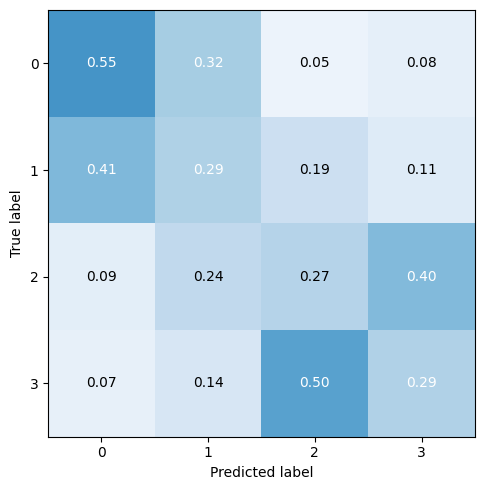

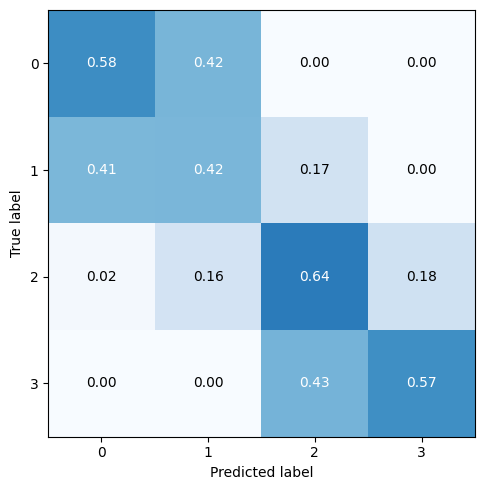

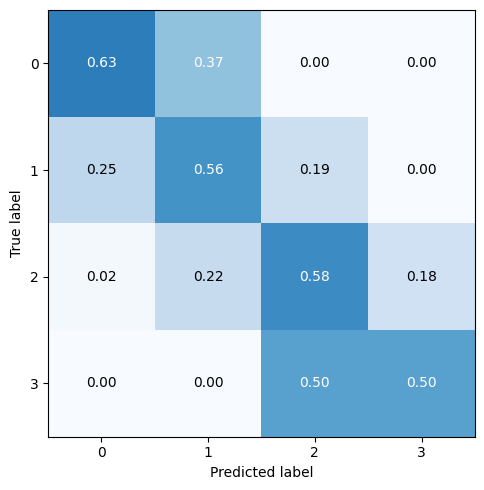

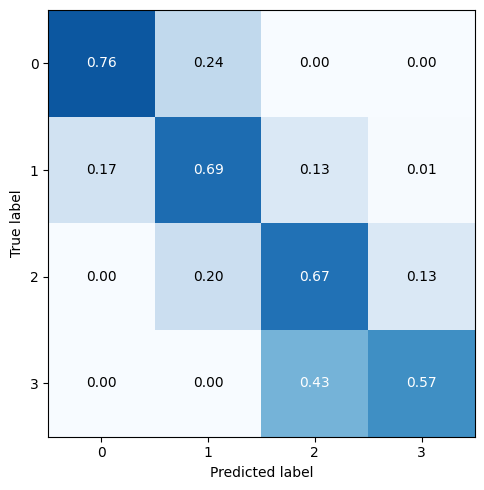

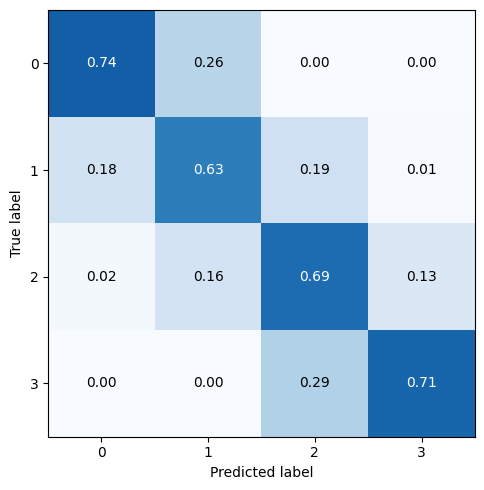

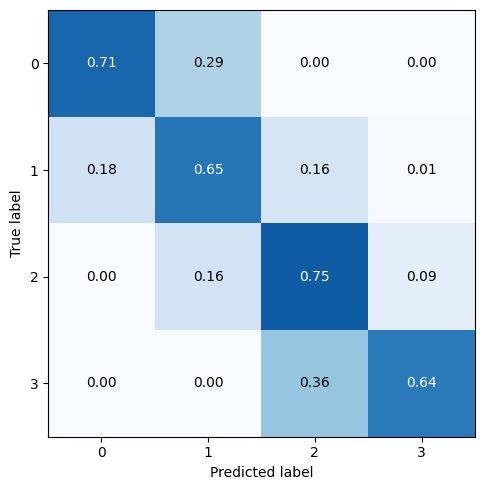

In [72]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_pvwmh[m][2], results_pvwmh[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_ADNI/{uncertainty_type}: {m}: full_cfields PVWMH fazekas prediction on ADNI")

In [73]:
results_pvwmh = {}

for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv1, colinear_threshold=ct1, n_splits=S,
                                 val_proportion=0.1, target="WMH_PV", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=True)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_pvwmh[model_type] = results

clinical_only, 0.27, 0.39
c+volume, 0.52, 0.63
cv_samples, 0.61, 0.65
cv_pred, 0.72, 0.75
cv_umap, 0.67, 0.72
cvps+umap, 0.67, 0.68


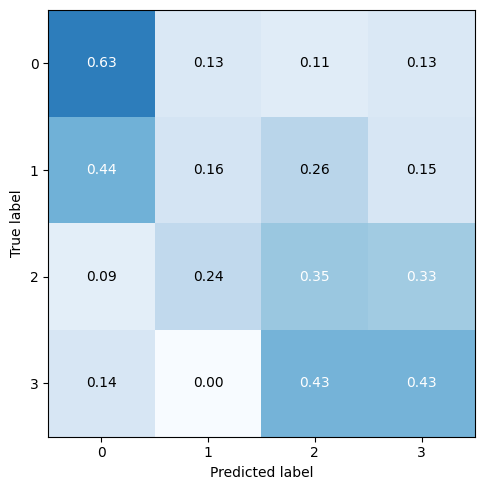

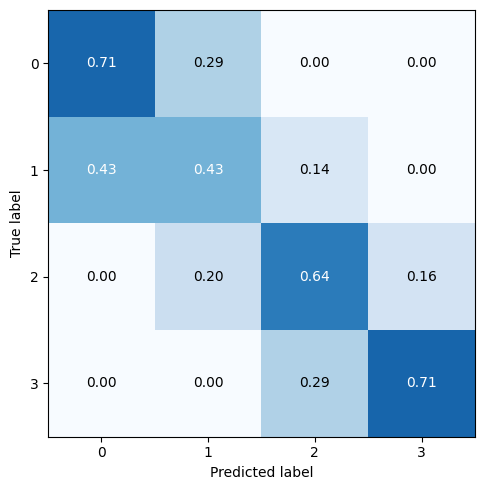

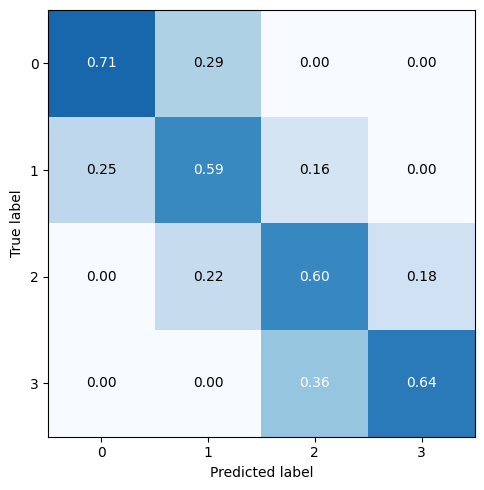

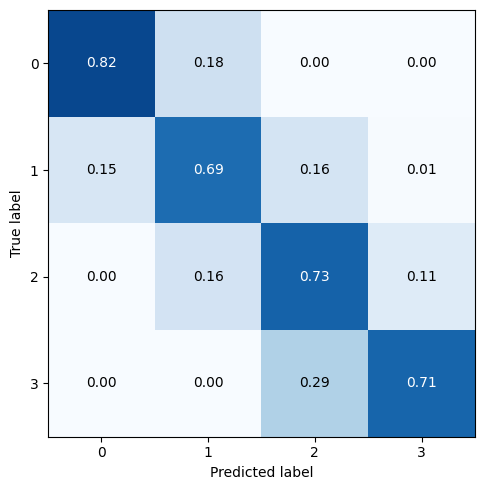

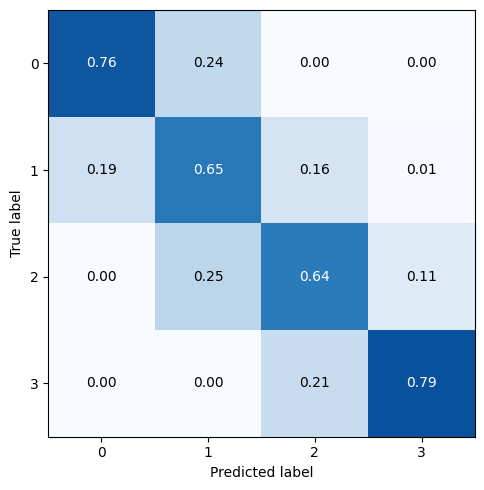

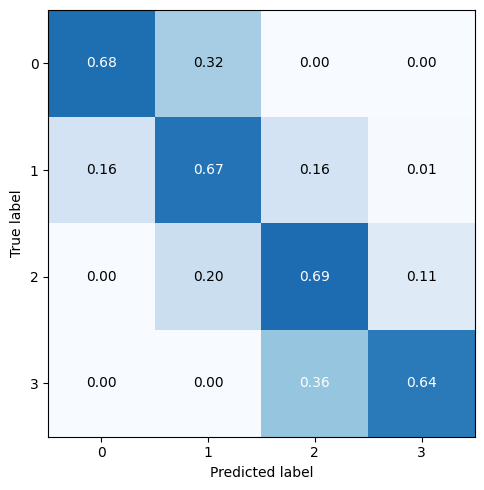

In [74]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_pvwmh[m][2], results_pvwmh[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_ADNI/{uncertainty_type}: {m}: limited_cfields PVWMH fazekas prediction on ADNI")

In [79]:
results_dwmh08 = {}
S = 12
for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=ct2, n_splits=S, val_proportion=0.1, target="WMH_Deep", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=False)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_dwmh08[model_type] = results


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

clinical_only, 0.41, 0.39


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

c+volume, 0.59, 0.59


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cv_samples, 0.61, 0.59


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cv_pred, 0.65, 0.65


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cv_umap, 0.6, 0.59


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cvps+umap, 0.64, 0.64


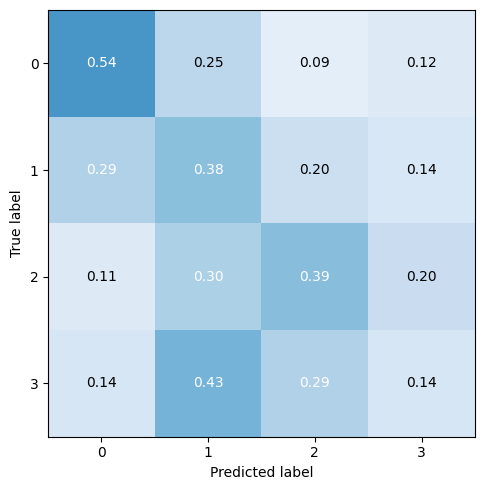

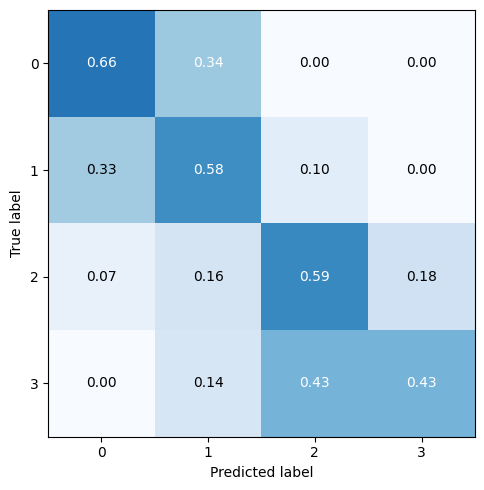

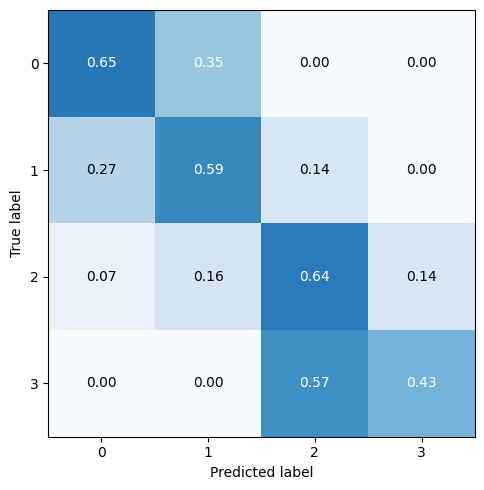

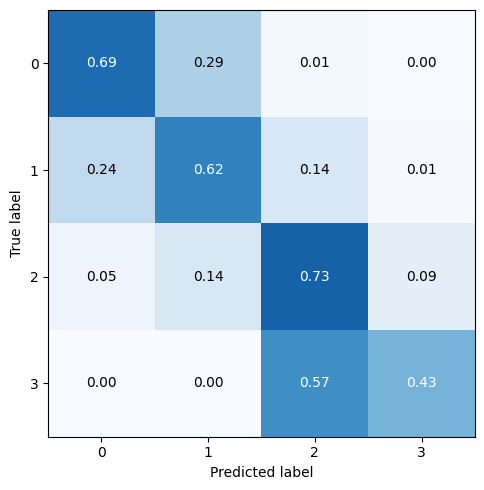

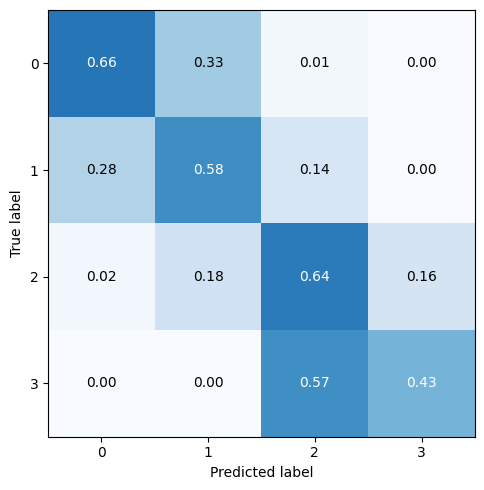

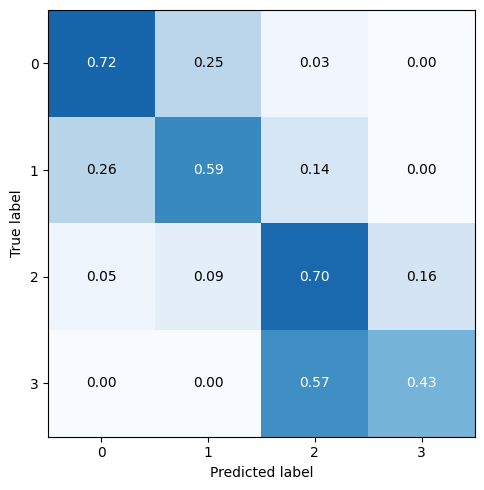

In [80]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_dwmh08[m][2], results_dwmh08[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_ADNI/{uncertainty_type}: {m}: full_cfields DWMH fazekas prediction on ADNI")

In [81]:
results_dwmh08 = {}
S = 12
for model_type in model_types:
    results = run_prediction_new(full_combined_df, model_type, clf=clf, thresholds_dict=thresholdsv2, colinear_threshold=ct2, n_splits=S, val_proportion=0.1, target="WMH_Deep", stratify_target=None, 
                   rescale=True, predict_val=False, verbose=False, metric='accuracy', do_log=False, log_feature_matches=log_feature_matches, 
                   rem_colinear_feats=True, colinear_ignores=target_fields, regression=False, use_limited_clinical_fields=True)
    print(f"{model_type}, {results[0]:.2}, {results[1]:.2}")
    results_dwmh08[model_type] = results

/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

clinical_only, 0.4, 0.4


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

c+volume, 0.61, 0.61


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cv_samples, 0.63, 0.63


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cv_pred, 0.64, 0.67


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cv_umap, 0.6, 0.61


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class i

cvps+umap, 0.64, 0.66


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=12.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(


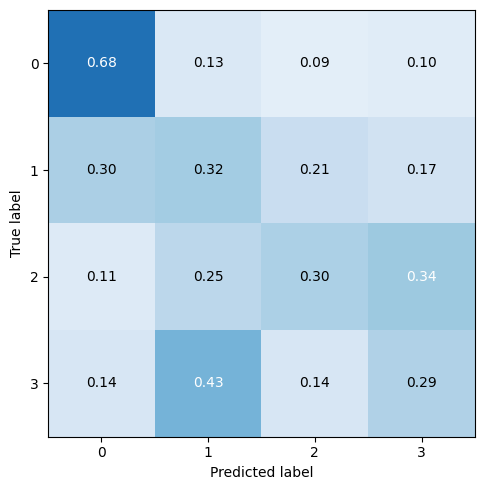

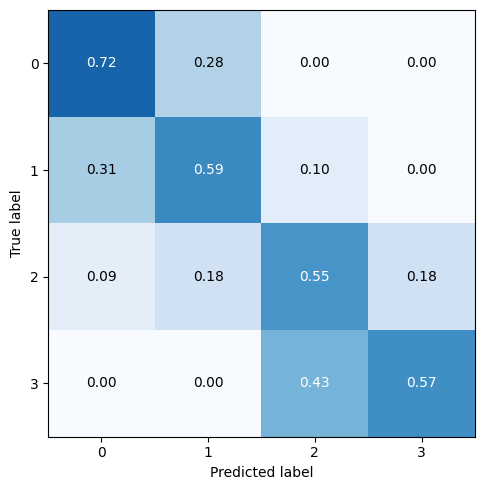

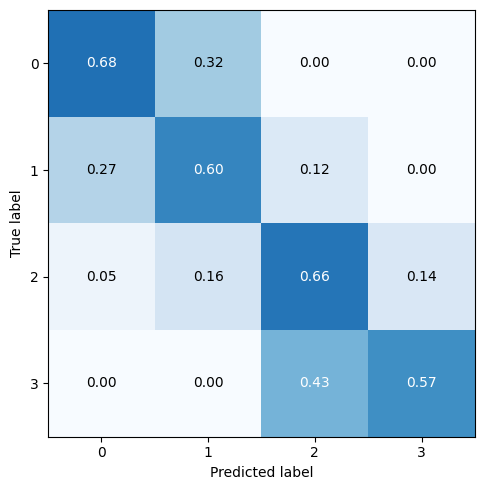

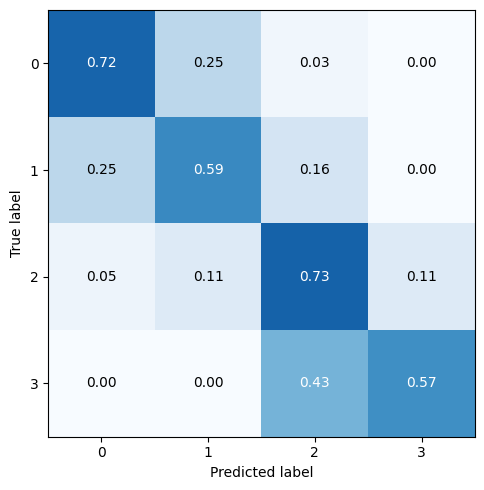

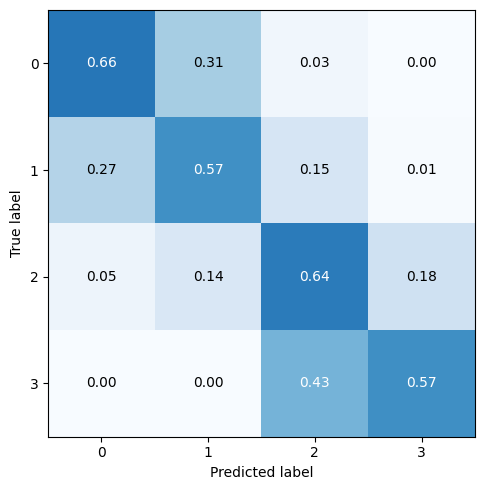

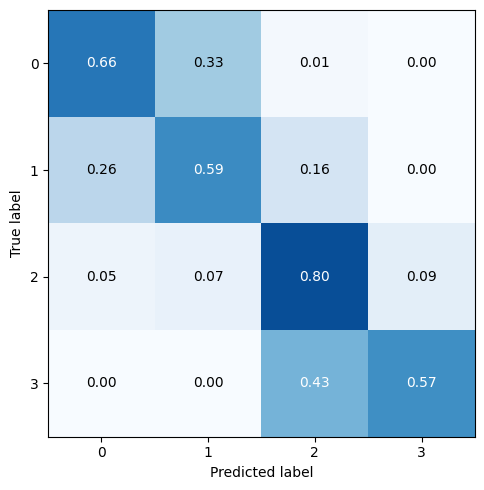

In [82]:
for m in model_types:
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(results_dwmh08[m][2], results_dwmh08[m][3], fig, ax)
    plt.savefig(f"confusion_matrices_ADNI/{uncertainty_type}: {m}: limited_cfields DWMH fazekas prediction on ADNI")